# 1. IMPORT LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML preprocessing and models
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
# from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

import joblib

In [2]:
import warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

# 2. LOAD DATA

In [3]:
X_full = pd.read_csv("Training.csv")
X_test = pd.read_csv("Testing.csv")

# Drop unwanted column
if "Unnamed: 133" in X_full.columns:
    X_full.drop("Unnamed: 133", axis=1, inplace=True)

print("Training shape:", X_full.shape)
print("Testing shape:", X_test.shape)

Training shape: (4920, 133)
Testing shape: (42, 133)


# 3. EXPLORATORY DATA ANALYSIS (EDA)

Missing values:
 Series([], dtype: int64)


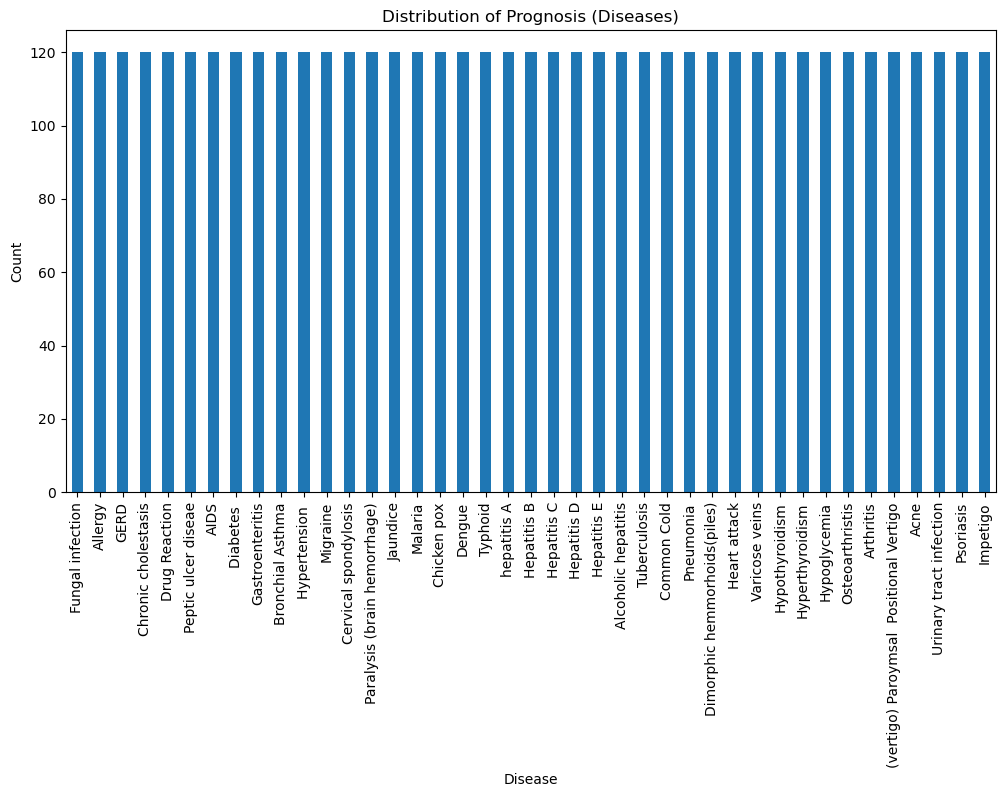

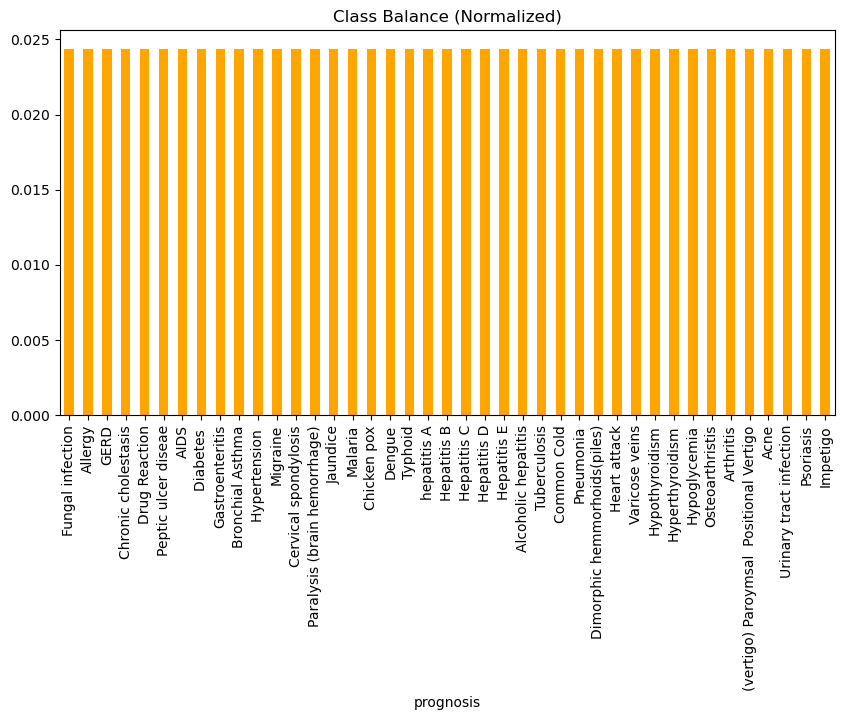

In [4]:
# Missing values
missing_data = X_full.isnull().sum()
print("Missing values:\n", missing_data[missing_data > 0])

# Target variable distribution
plt.figure(figsize=(12, 6))
X_full["prognosis"].value_counts().plot(kind="bar")
plt.title("Distribution of Prognosis (Diseases)")
plt.xlabel("Disease")
plt.ylabel("Count")
plt.show()

# Class balance (normalized)
plt.figure(figsize=(10, 5))
X_full["prognosis"].value_counts(normalize=True).plot(kind="bar", color="orange")
plt.title("Class Balance (Normalized)")
plt.show()

# 4. PREPROCESSING

In [5]:
encoder = LabelEncoder()
X_full["prognosis"] = encoder.fit_transform(X_full["prognosis"])

X = X_full.drop("prognosis", axis=1).values
y = X_full["prognosis"].values

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# 5. MULTIPLE MODELS TRAINING

In [6]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    # "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42),
    "SVM": SVC(kernel="rbf", probability=True, random_state=42),
    "Naive Bayes": GaussianNB()
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    acc = accuracy_score(y_val, preds)
    f1 = f1_score(y_val, preds, average="macro")
    results.append((name, acc, f1))
    print(f"{name} → Accuracy: {acc:.4f}, F1: {f1:.4f}")

results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "F1-Macro"])
print("\nInitial Performance Comparison:\n", results_df)

Logistic Regression → Accuracy: 1.0000, F1: 1.0000
Random Forest → Accuracy: 1.0000, F1: 1.0000
Gradient Boosting → Accuracy: 1.0000, F1: 1.0000
SVM → Accuracy: 1.0000, F1: 1.0000
Naive Bayes → Accuracy: 1.0000, F1: 1.0000

Initial Performance Comparison:
                  Model  Accuracy  F1-Macro
0  Logistic Regression       1.0       1.0
1        Random Forest       1.0       1.0
2    Gradient Boosting       1.0       1.0
3                  SVM       1.0       1.0
4          Naive Bayes       1.0       1.0


In [8]:
# ============================================
# 6. HYPERPARAMETER TUNING (RF + XGB)
# ============================================

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# ---- Random Forest ----
rf_params = {
    "n_estimators": [100, 250, 500],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5]
}
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_params,
    cv=cv,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=1
)
rf_grid.fit(X_train, y_train)
print("Best RF Params:", rf_grid.best_params_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best RF Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}


# 7. FINAL MODEL COMPARISON (With Tuned Models)

In [9]:
tuned_models = {
    "Logistic Regression": models["Logistic Regression"],
    "Random Forest (Tuned)": rf_grid.best_estimator_,
    "Gradient Boosting": models["Gradient Boosting"],
    # "XGBoost (Tuned)": xgb_grid.best_estimator_,
    "SVM": models["SVM"],
    "Naive Bayes": models["Naive Bayes"]
}

final_results = []
for name, model in tuned_models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    acc = accuracy_score(y_val, preds)
    f1 = f1_score(y_val, preds, average="macro")
    final_results.append((name, acc, f1))
    print(f"{name} → Accuracy: {acc:.4f}, F1: {f1:.4f}")

final_df = pd.DataFrame(final_results, columns=["Model", "Accuracy", "F1-Macro"])
print("\nFinal Model Comparison (After Tuning):\n", final_df)

Logistic Regression → Accuracy: 1.0000, F1: 1.0000
Random Forest (Tuned) → Accuracy: 1.0000, F1: 1.0000
Gradient Boosting → Accuracy: 1.0000, F1: 1.0000
SVM → Accuracy: 1.0000, F1: 1.0000
Naive Bayes → Accuracy: 1.0000, F1: 1.0000

Final Model Comparison (After Tuning):
                    Model  Accuracy  F1-Macro
0    Logistic Regression       1.0       1.0
1  Random Forest (Tuned)       1.0       1.0
2      Gradient Boosting       1.0       1.0
3                    SVM       1.0       1.0
4            Naive Bayes       1.0       1.0


# 8. SELECT BEST MODEL

In [10]:
best_model_name = final_df.sort_values("F1-Macro", ascending=False).iloc[0]["Model"]
print("\nBest Model Selected:", best_model_name)
final_model = tuned_models[best_model_name]


Best Model Selected: Logistic Regression


# 9. TEST SET EVALUATION

In [11]:
X_test["prognosis"] = encoder.transform(X_test["prognosis"])
X_test_ = X_test.drop("prognosis", axis=1).values
y_test_ = X_test["prognosis"].values
X_test_ = scaler.transform(X_test_)

test_preds = final_model.predict(X_test_)
test_acc = accuracy_score(y_test_, test_preds)
test_f1 = f1_score(y_test_, test_preds, average="macro")
print("\nTest Performance → Accuracy: {:.4f}, F1: {:.4f}".format(test_acc, test_f1))



Test Performance → Accuracy: 0.9762, F1: 0.9837


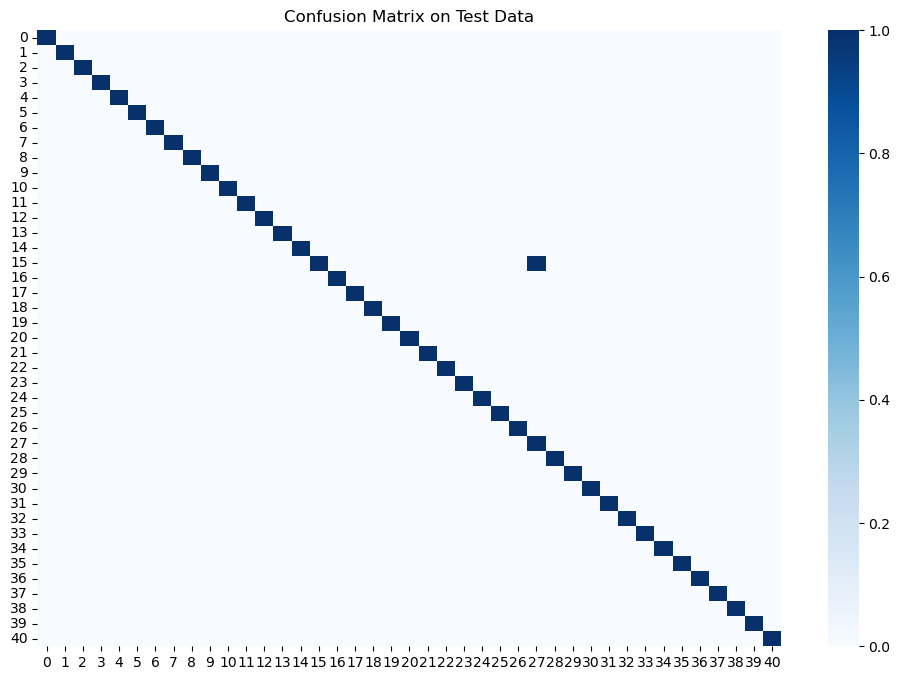

In [12]:
# Confusion Matrix
plt.figure(figsize=(12, 8))
cm = confusion_matrix(y_test_, test_preds)
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("Confusion Matrix on Test Data")
plt.show()

In [13]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# 10. SAVE ARTIFACTS

In [14]:
joblib.dump(final_model, "best_model.joblib")
joblib.dump(encoder, "encoder.joblib")
joblib.dump(scaler, "scaler.joblib")
symptom_columns = X_full.drop("prognosis", axis=1).columns
joblib.dump(symptom_columns, "symptom_columns.joblib")

print("\nBest tuned model, encoder, scaler, and features saved successfully!")


Best tuned model, encoder, scaler, and features saved successfully!
